## Libraries

In [273]:
# Standard Library Imports
import codecs
import json
import math
from os import path

# Third-Party Imports
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import textacy
import textacy.tm
import textacy.preprocessing
import umap.umap_ as umap
from wordcloud import WordCloud, get_single_color_func
from PIL import Image, ImageDraw
import multidict as multidict
from scipy.spatial import ConvexHull
from scipy import interpolate

# Specific Imports
# from pointgrid import align_points_to_grid

## Dataset

In [274]:
with open('PAP.md', 'r') as f: md = f.read()
pages = md.split("\n") # Split in pages

print(f"The number of elements is {len(pages)}")

The number of elements is 56


## Text Analysis

In [275]:
en = textacy.load_spacy_lang("en_core_web_lg", disable=("parser",))

docs = [] # spaCy collector

for index, page in enumerate(pages):
    doc = textacy.make_spacy_doc(page, lang=en)
    docs.append(doc)

print(f"The number of elements is {len(docs)}")    

The number of elements is 56


# Lematization

In [276]:
stopwords = set([
    'pap', 'the', 'and', 'for', 'with', 'that', 'this', 'from', 'are', 'was', 
    'were', 'has', 'have', 'had', 'not', 'but', 'also', 'which', 'they', 'them', 
    'their', 'your', 'yours', 'ourselves', 'themselves', 'what', 'when', 'where', 
    'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 
    'some', 'such', 'only', 'own', 'same', 'than', 'too', 'very', 'just', 'don', 
    'should', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'mightn', 
    'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn', 
    'somewhat', 'instead', 'even', 'often', 'perhaps', 'therefore', 'although', 
    'because', 'whether', 'unless', 'however', 'although', 'yet', 'and/or', 
    'involving', 'among', 'per', 'during', 'like', 'before', 'after', 'down', 
    'over', 'under', 'between', 'across', 'along', 'behind', 'through', 'until', 
    'around', 'amongst', 'throughout', 'despite', 'within', 'above', 'below', 
    'inside', 'outside', 'year', 'vey', 'use', 'way', 'zur'
]) # Define a list of specific stopwords

lemmas_collector = [] # Initialize an empty list to store the lemmas

# Loop through each document in the `docs` collection
for doc in docs:

    config = partial(textacy.extract.ngrams, n=[1], include_pos={'NOUN'})  # Define n-gram extraction
    terms = textacy.extract.terms(doc, ngs=config)  # Extract terms
    lemmas = textacy.extract.terms_to_strings(terms, by="lemma")  # Convert terms to lemmas
    
    lemmas = [l for l in lemmas if l not in stopwords]  # Remove exact match stopwords
    lemmas = [l for l in lemmas if '||||' not in l]  # Remove terms with '||||' as substring
    lemmas = [l for l in lemmas if len(l) > 2]  # Remove terms with 2 or fewer characters


    lemmas_collector.append(list(lemmas))  # Collect the lemmas

# Create a document-term matrix (DTM) from the collected lemmas
doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    lemmas_collector, tf_type="linear", idf_type="smooth"  # Build DTM with TF-IDF
)

# Output
print('Vocabulary\'s docs are', doc_term_matrix.shape[0], 'and terms are', doc_term_matrix.shape[1], '\n')


# Print top 100 terms
sorted_terms = sorted(
    {term: np.array(doc_term_matrix.sum(axis=0)).flatten()[idx] for term, idx in dictionary.items()}.items(),
    key=lambda item: item[1], reverse=True
)

print("\n".join([f"{term}: {frequency}" for term, frequency in sorted_terms[0:10]]))

Vocabulary's docs are 56 and terms are 457 

relation: 73.99258672069362
line: 71.03842382796671
graph: 67.56152681125845
reasoning: 52.04014011783328
form: 49.03502240137912
number: 48.37905373847161
point: 47.417755618475425
object: 41.106992622607564
spot: 41.106992622607564
question: 40.9303138887448


## UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/peirce/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


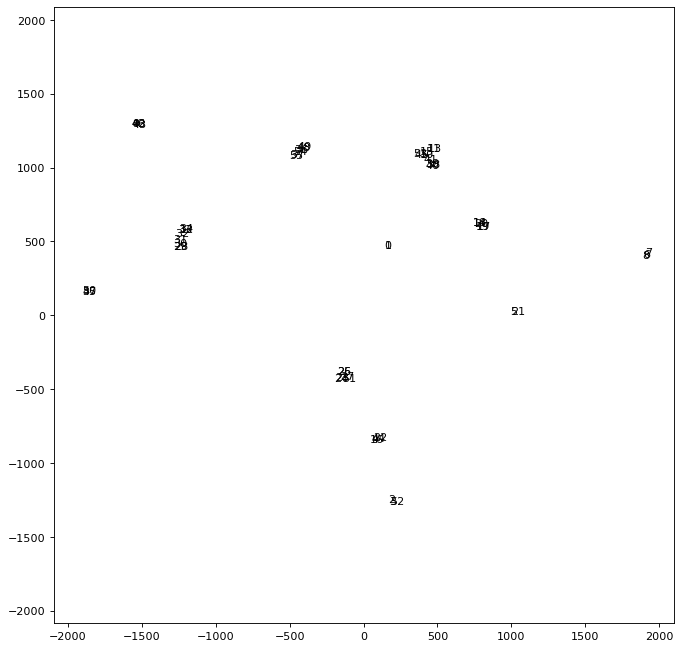

In [277]:
# UMAP
reducer = umap.UMAP(random_state=2, n_components=2, n_neighbors=2, min_dist=0.01, metric='hellinger')
embedding = reducer.fit_transform(doc_term_matrix)

# Normalization
embedding = embedding * 100 # Multiply by 100
# embedding = align_points_to_grid(embedding)

# Swap axes for horizontal position
ptp = np.ptp(embedding, axis=0)
if ptp[1]> ptp[0]:
    embedding[:, [1, 0]] = embedding[:, [0, 1]]

# Set value starting from 0
embedding[:, 0] = embedding[:, 0] - embedding[:, 0].min()
embedding[:, 1] = embedding[:, 1] - embedding[:, 1].min()

# Set origin at the middle
ptp = np.ptp(embedding, axis=0)
embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

# Transform coordinates in integer
embedding = embedding.astype(int)

# Draw
plt.figure(figsize=(10,10), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1], s=0)
plt.axis('equal')

for i, row in enumerate(embedding):
    text = plt.annotate(i, (row[0], row[1]))
    text.set_fontsize(10)

plt.show()
    

## Cluster Identification

In [278]:
# Perform clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_method='leaf')
clusterer.fit(embedding)

# Get cluster labels
cluster_labels = clusterer.labels_

# Group clusters, filtering out noise and small clusters within the loop
scale = 4
clusters = []

for label in set(cluster_labels):
    if label == -1:  # Skip noise clusters
        continue

    # Get indices of points in the cluster
    cluster = np.where(cluster_labels == label)[0]

    if len(cluster) < 3:  # Skip clusters with fewer than 3 elements
        continue

    # Preprocess cluster points
    cluster_points = embedding[cluster] * scale
    points = [(x - cluster_points[:, 0].min(), y - cluster_points[:, 1].min()) for x, y in cluster_points]

    if np.linalg.matrix_rank(points - np.mean(points, axis=0)) < 2:  # Skip degenerate clusters
        continue

    # Generate convex hull and interpolated points
    hull = ConvexHull(points)
    hull_points = np.vstack([hull.points[hull.vertices], hull.points[hull.vertices][0]])
    dist = np.insert(np.cumsum(np.sqrt(np.sum(np.diff(hull_points, axis=0)**2, axis=1))), 0, 0)
    spline, _ = interpolate.splprep([hull_points[:, 0], hull_points[:, 1]], u=dist, s=0)
    interp_x, interp_y = interpolate.splev(np.linspace(0, dist[-1], 50), spline)
    interp_points = list(zip(interp_x, interp_y))

    # Create mask
    width, height = int(cluster_points[:, 0].max() - cluster_points[:, 0].min()), int(cluster_points[:, 1].max() - cluster_points[:, 1].min())
    img = Image.new("RGBA", (width, height), (255, 255, 255))
    ImageDraw.Draw(img).polygon(interp_points, fill=(0, 0, 0))
    mask = np.array(img)

    # Collect text and calculate word frequencies
    text = ' '.join(sum((lemmas_collector[i] for i in cluster), []))
    dictionary = {word: text.split().count(word) for word in set(text.split())}

    # Generate and save word cloud
    wc = WordCloud(
        mode="RGBA", color_func=lambda *args, **kwargs: (0, 0, 0),
        font_path=path.join('Lato-Regular.ttf'), mask=mask,
        normalize_plurals=False, prefer_horizontal=1,
        margin=40, background_color=None,
        min_font_size=10, max_font_size=100, relative_scaling=0
    ).generate_from_frequencies(dictionary)
    wc.to_file(path.join("../src/wordclouds/", f"{label:02}.png"))

    clusters.append(cluster)  # Add valid cluster to the list
    print(f"Processed cluster {label}, elements={len(cluster)}")

print(f"Final number of clusters: {len(clusters)}")

Processed cluster 0, elements=7
Processed cluster 1, elements=6
Processed cluster 2, elements=6
Processed cluster 3, elements=4
Processed cluster 4, elements=5
Processed cluster 5, elements=10
Processed cluster 6, elements=4
Processed cluster 7, elements=3
Final number of clusters: 8


# Save Files

In [279]:
# Convert clusters to a JSON-serializable format
serializable_clusters = [cluster.tolist() if isinstance(cluster, np.ndarray) else cluster for cluster in clusters]

# Save the data to JSON files
json.dump(embedding.tolist(), codecs.open('../src/data/embedding.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(lemmas_collector, codecs.open('../src/data/lemmas.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)
json.dump(serializable_clusters, codecs.open('../src/data/clusters.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

print("Files saved successfully.")

Files saved successfully.
